# Introduction to Data Science - Week 4 Probability and Hypothesis Testing

In [2]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chisquare

matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.style.use('ggplot')

In [3]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## Dataset

The training dataset for this week comes from [London Weather Data](https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data). This dataset records historical weather data in London from 1979 to 2021. The measurements in this specific dataset are recorded by a meteorological station near London Heathrow Airport in the United Kingdom.

In [4]:
# Read in data
df = pd.read_csv("../data/london_weather.csv")
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [5]:
df.fillna(0, inplace=True)
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,0.0
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,0.0
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,0.0
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,0.0


In [6]:
df.columns

Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')

1. date - recorded date of measurement - (int)
   
2. cloud_cover - cloud cover measurement in oktas - (float)
   
3. sunshine - sunshine measurement in hours (hrs) - (float)
4. global_radiation - irradiance measurement in Watt per square meter (W/m2) - (float)
5. max_temp - maximum temperature recorded in degrees Celsius (°C) - (float)
6. mean_temp - mean temperature in degrees Celsius (°C) - (float)
7. min_temp - minimum temperature recorded in degrees Celsius (°C) - (float)
8. precipitation - precipitation measurement in millimeters (mm) - (float)
9.  pressure - pressure measurement in Pascals (Pa) - (float)
10. snow_depth - snow depth measurement in centimeters (cm) - (float)

## Fit Function

This function is used to go through all of the distributions, calculate the probability density function for each prior distribution, then it will find the best one. 

In [7]:
def best_fit_distribution(data, dist_names, bins, ax=None, legend=True):
    """Model data by finding best fit distribution to data"""
    #Code adapted from: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in dist_names if not d in ['levy_stable', 'studentized_range']]):
        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, legend=legend, label=distribution.name)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    return sorted(best_distributions, key=lambda x:x[2])

This function will plot all of the different distributions we want to try and fit to the data on one overlayed plot, then follow that by showing use the plot of the best fitting function:

In [8]:
def compare_and_plot_distributions(data, dist_names, bins, legend=True):
    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=bins, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'], legend=legend)
    ax.set_ylabel('Density')

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, dist_names, bins, ax, legend)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    plt.legend(loc='upper right')
    ax = pdf.plot(lw=2, label='PDF', legend=legend)
    ax.set_ylabel('Density')
    data.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=legend, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'Best fit distribution \n' + dist_str)

I have selected some common probability distribution models:

1. **Normal Distribution**

2. **Exponential Distribution**

3. **Skew Normal Distribution**

4. **Lognormal Distribution**

In [9]:
dist_names = ['norm', 'expon', 'skewnorm', 'lognorm']

##  What are the overall climatic characteristics of London?

First, I want to explore the overall weather characteristics of London from four aspects: **cloud cover**, **sunshine**, **temperature**, and **precipitation**.

###  Cloud Cover

In [10]:
cloud_cover = df["cloud_cover"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


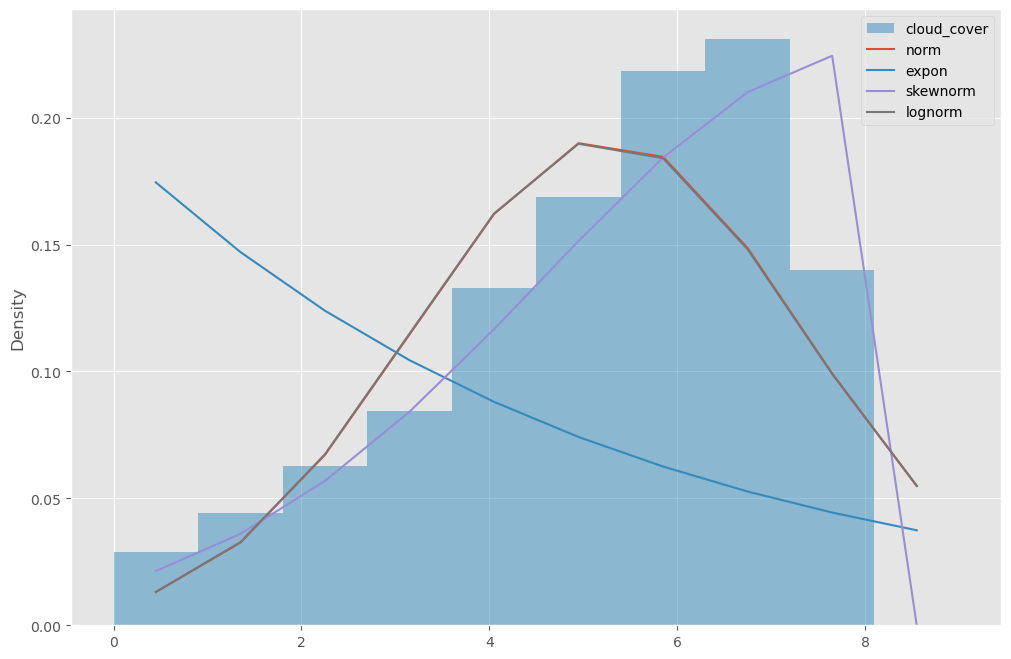

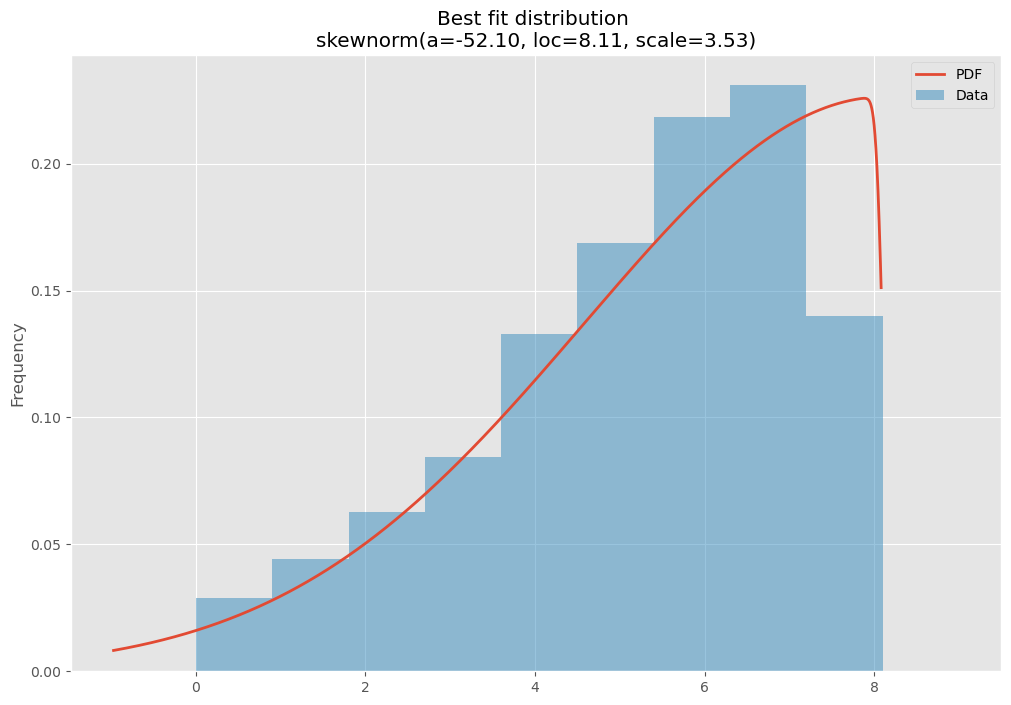

In [11]:
# I have to choose 10 for bins due to the cloud_cover dataset's feature, so the lines are not very smooth.
compare_and_plot_distributions(cloud_cover, dist_names, 10)

### Sunshine

In [12]:
sunshine = df["sunshine"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


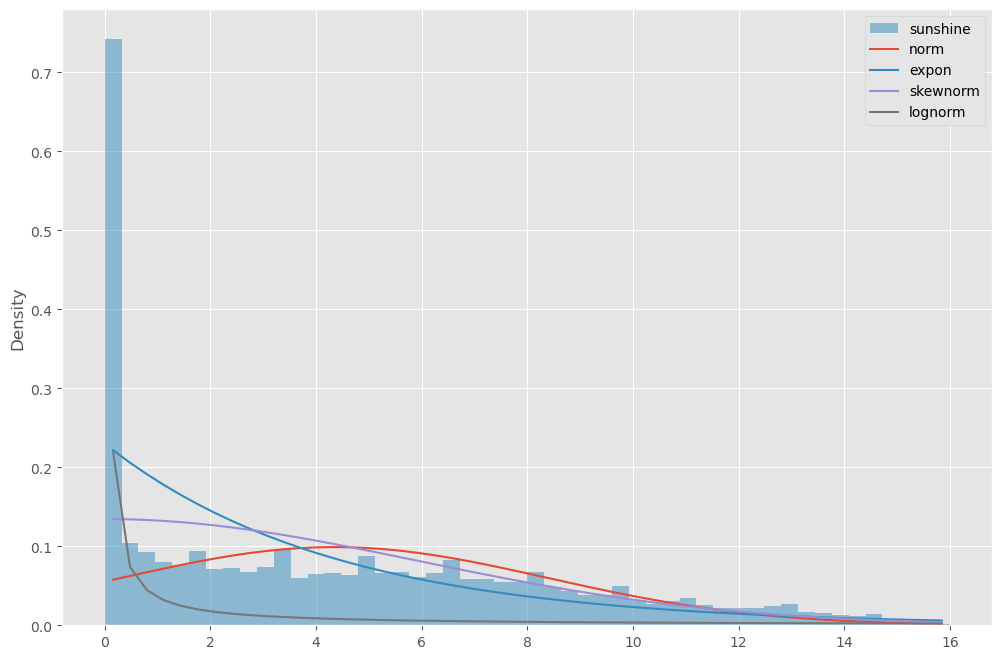

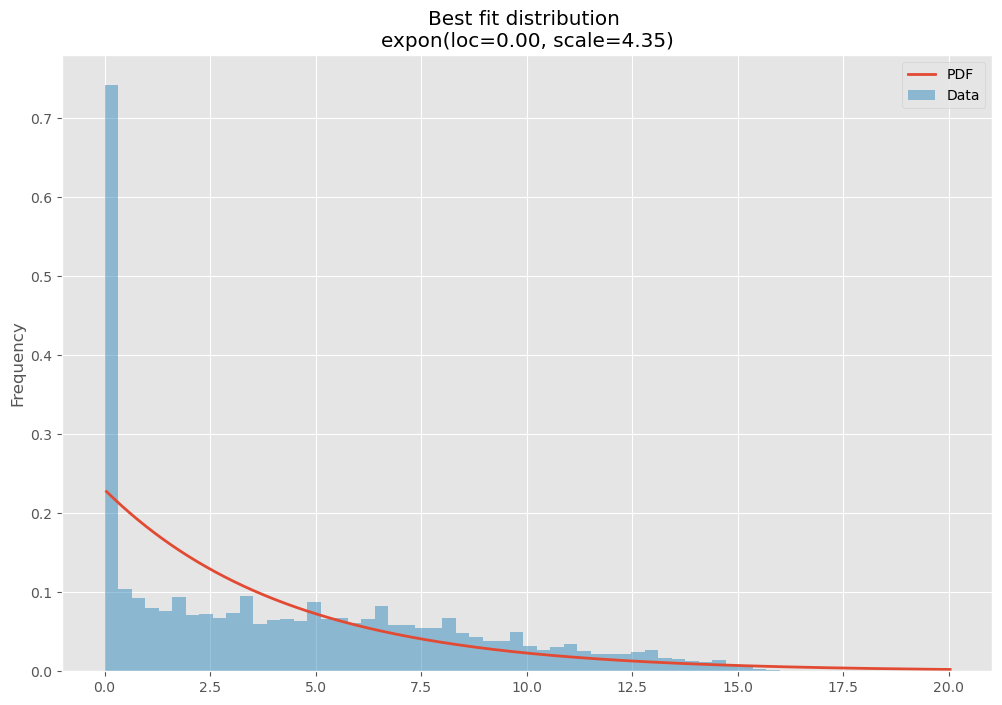

In [13]:
compare_and_plot_distributions(sunshine, dist_names, 50)

In [14]:
global_radiation = df["global_radiation"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


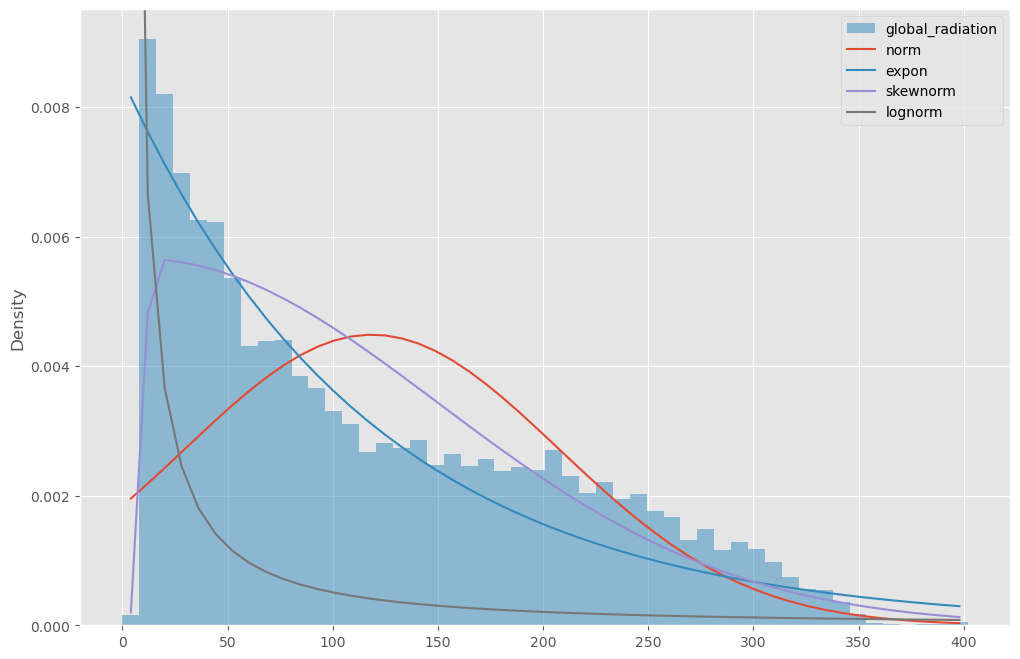

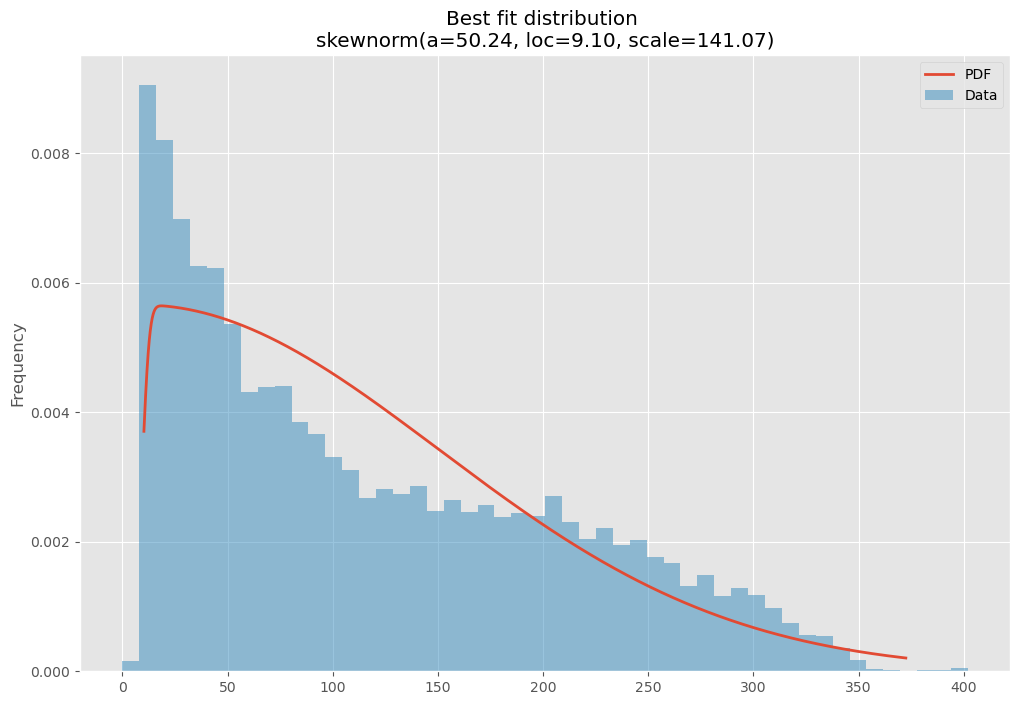

In [15]:
compare_and_plot_distributions(global_radiation, dist_names, 50)

### Temperature

In [16]:
temperature = df["mean_temp"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


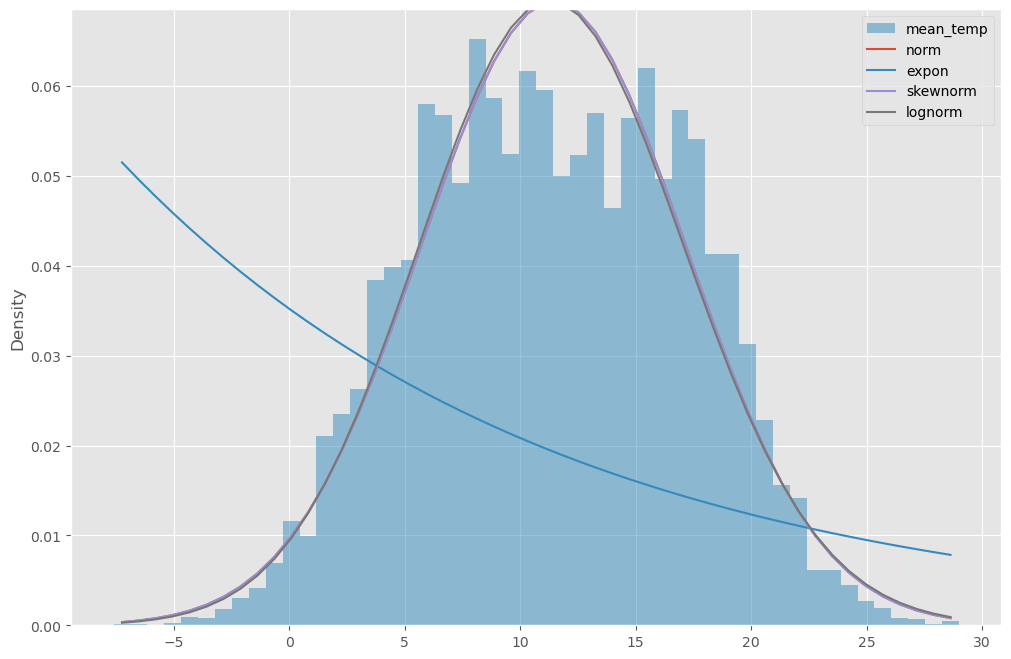

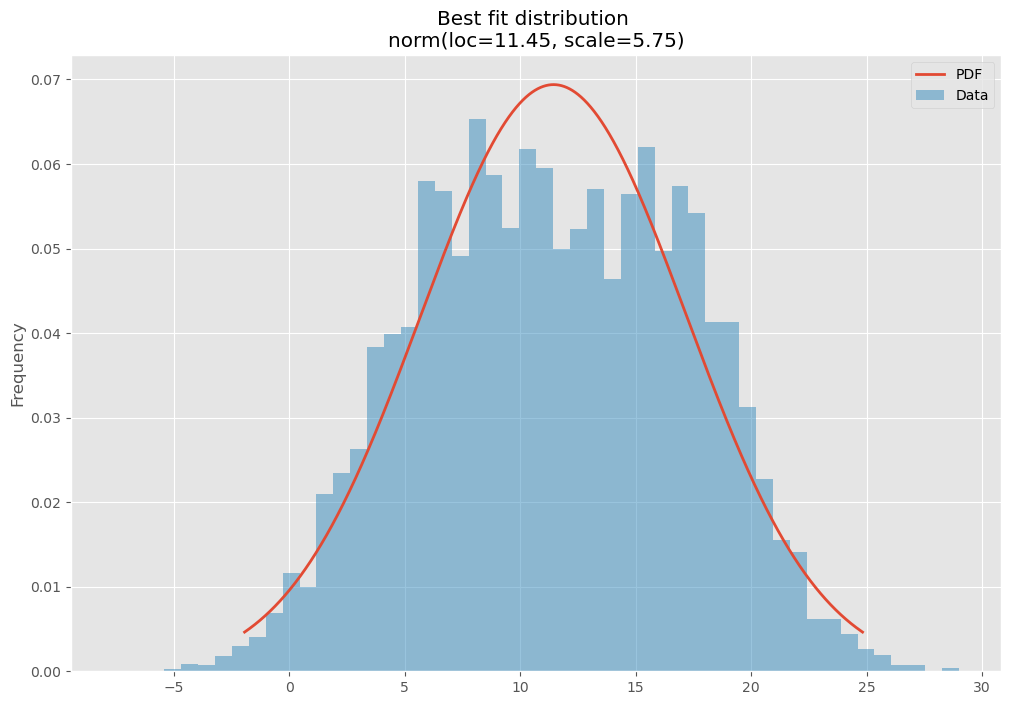

In [17]:
compare_and_plot_distributions(temperature, dist_names, 50)

In [18]:
df['temp_difference'] = df['max_temp'] - df['min_temp']
temp_difference = df["temp_difference"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


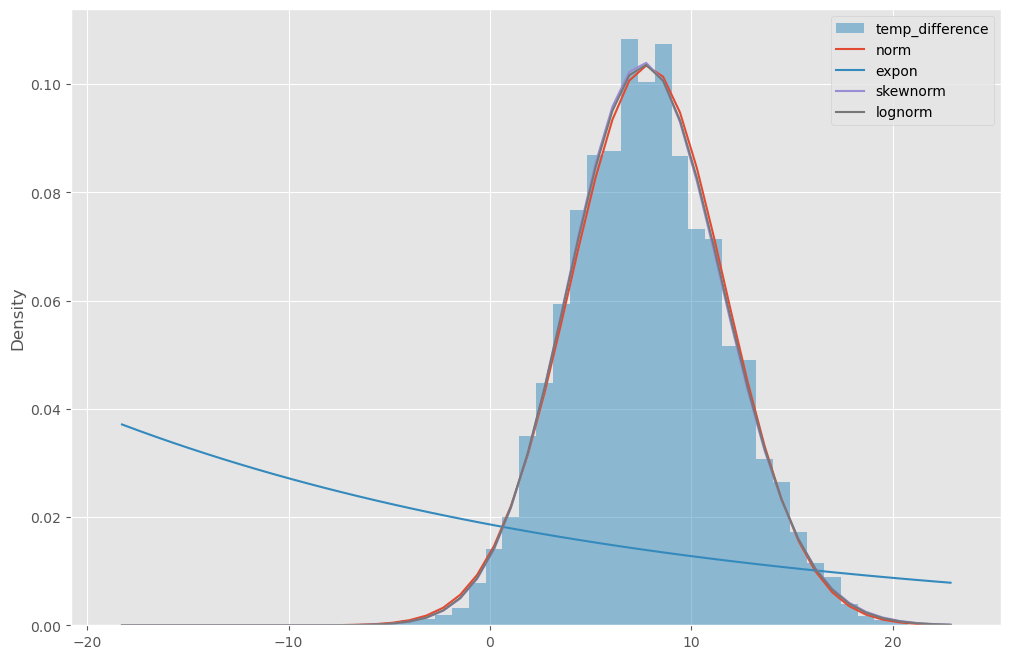

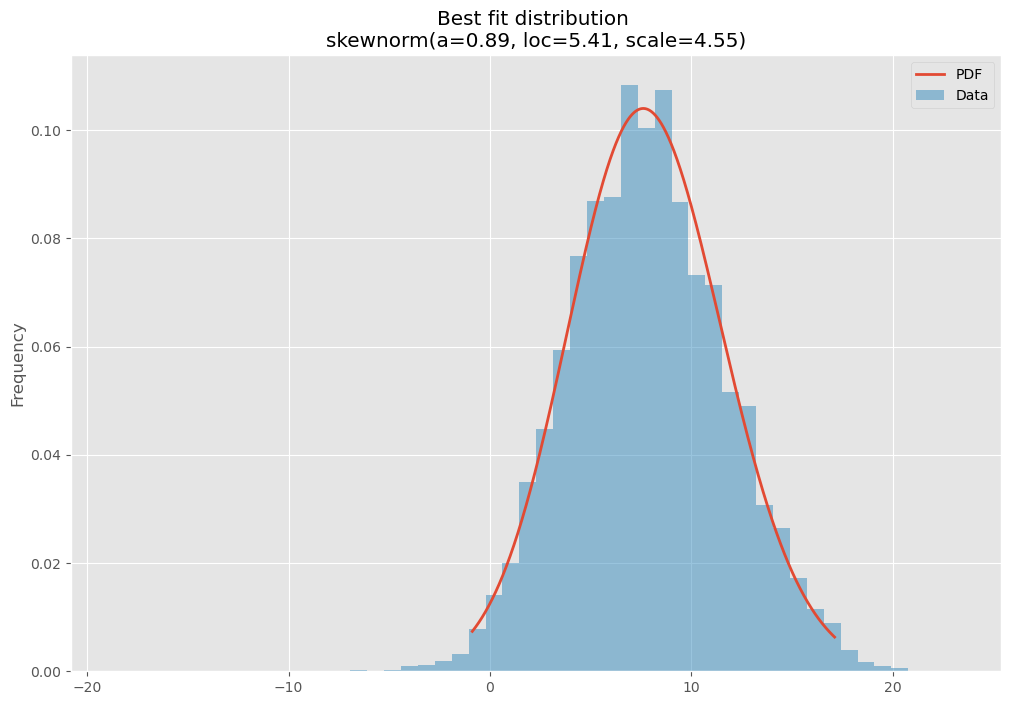

In [19]:
compare_and_plot_distributions(temp_difference, dist_names, 50)

### Precipitation

In [20]:
precipitation = df["precipitation"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


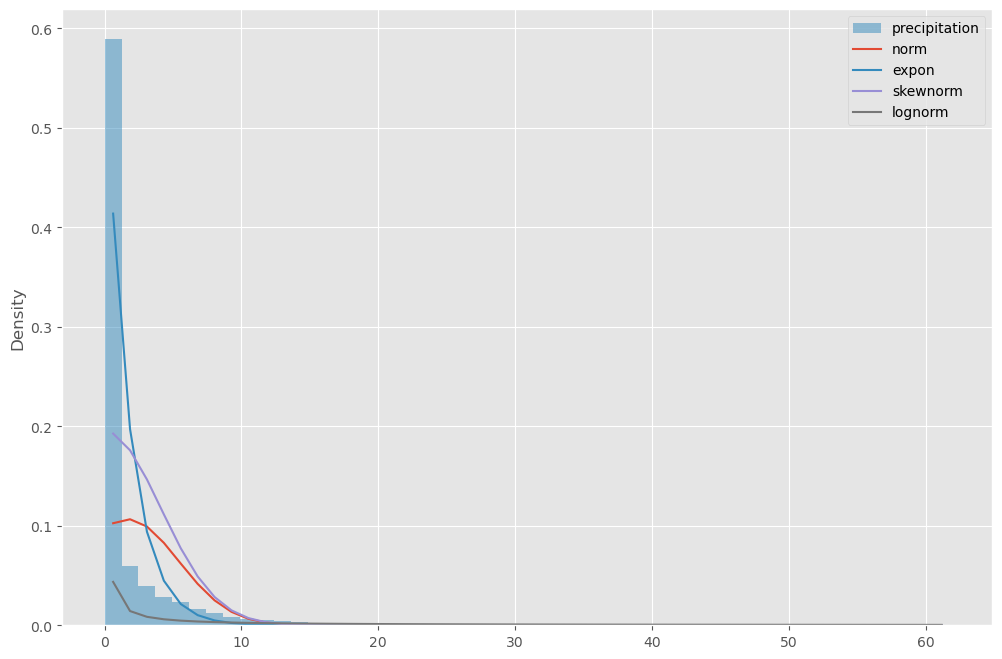

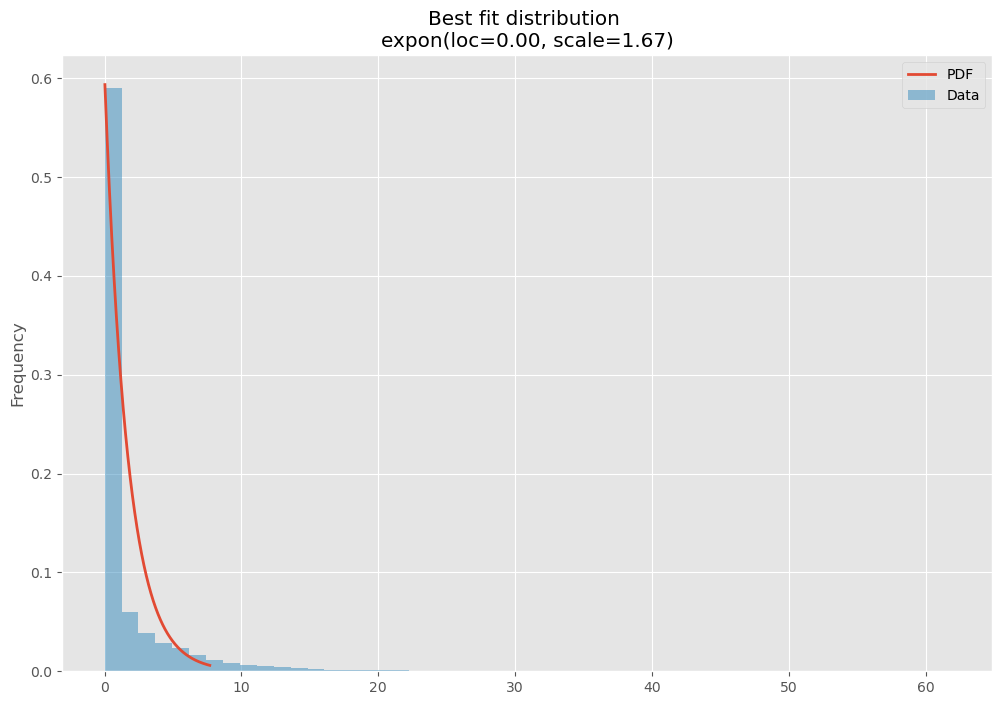

In [21]:
compare_and_plot_distributions(precipitation, dist_names, 50)

## Is the number of rainy days evenly distributed across the seasons in London?

A: No.

In [22]:
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["month"] = df["date"].dt.month

def get_season(month):
    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Autumn"
    else:
        return "Winter"

df["season"] = df["month"].apply(get_season)

In [23]:
# Calculate the number of rainy days for each season
rainy_days_by_season = df[df["precipitation"] > 0].groupby("season")["precipitation"].count()

# Calculate the probability of rainy days for each season
total_days_by_season = df.groupby("season")["precipitation"].count()
rainy_probs_by_season = rainy_days_by_season / total_days_by_season

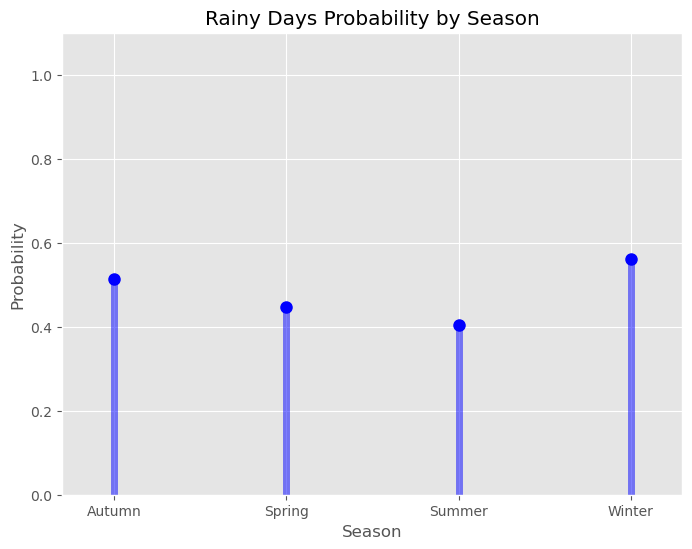

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(rainy_probs_by_season.index, rainy_probs_by_season, 'bo', ms=8)
ax.vlines(rainy_probs_by_season.index, 0, rainy_probs_by_season, colors='b', lw=5, alpha=0.5)
ax.set_ylim(ymin=0, ymax=1.1)
ax.set_xticks(rainy_probs_by_season.index)
ax.set_title("Rainy Days Probability by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Probability")
plt.margins(0.1)
plt.show()

In [25]:
# Chi-squared test
rainy_result = chisquare(rainy_days_by_season)
print(f"Our p-value is {rainy_result.pvalue:.4f}")

Our p-value is 0.0000


## Is there a rising trend in the annual average temperature in London over the past 42 years?

A: Yes

In [26]:
df["year"] = pd.to_datetime(df["date"], format='%Y%m%d').dt.year
year = df["year"]

In [27]:
# Calculate the annual average temperature
annual_mean_temp = df.groupby("year")["mean_temp"].mean()

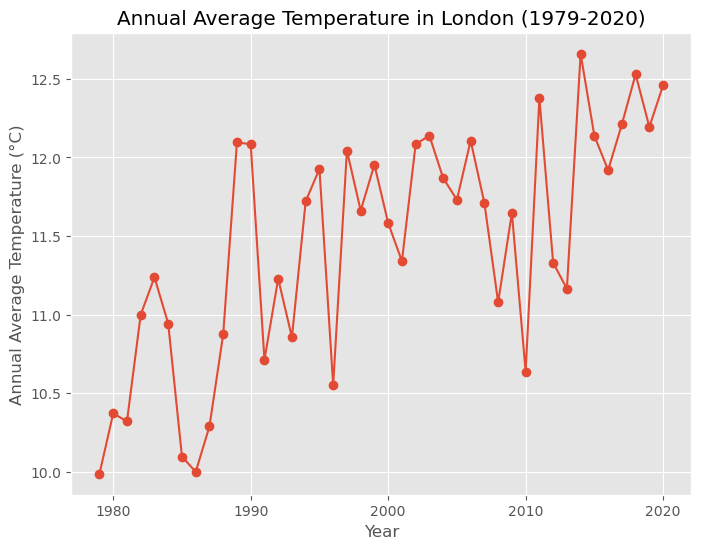

In [28]:
plt.plot(annual_mean_temp.index, annual_mean_temp, marker='o')
plt.xlabel('Year')
plt.ylabel('Annual Average Temperature (°C)')
plt.title('Annual Average Temperature in London (1979-2020)')
plt.grid(True)
plt.show()

In [29]:
from scipy.stats import kendalltau
tau, p_value = kendalltau(annual_mean_temp.index, annual_mean_temp.values)
print(p_value)
if p_value < 0.05:
    print("There is a significant trend.")
else:
    print("There is no significant trend.")

5.602359722706978e-06
There is a significant trend.


## Is there a rising trend in the annual total precipitation in London over the past 42 years?

A: No

In [31]:
# Calculate the total precipitation
annual_precipitation = df.groupby("year")["precipitation"].sum()

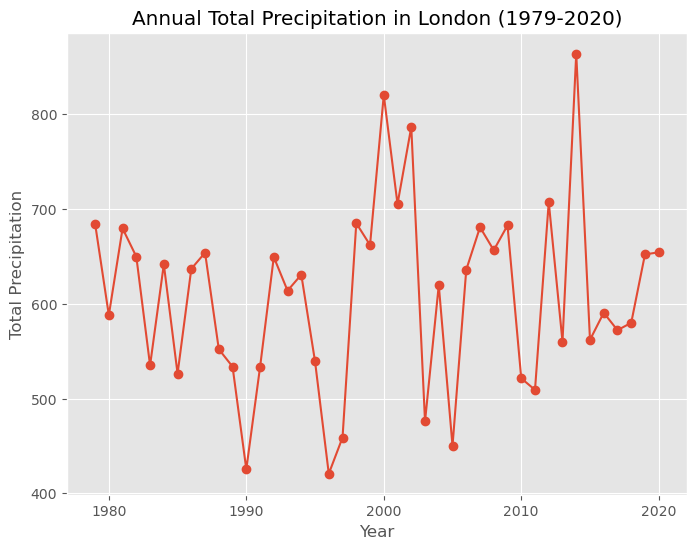

In [32]:
plt.plot(annual_precipitation.index, annual_precipitation, marker='o')
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Annual Total Precipitation in London (1979-2020)')
plt.grid(True)
plt.show()

In [37]:
tau, p_value = kendalltau(annual_precipitation.index, annual_precipitation.values)
print(p_value)
if p_value < 0.05:
    print("There is a significant trend.")
else:
    print("There is no significant trend.")

0.5804641579282053
There is no significant trend.


## Is there a rising trend in the annual average sunshine radiation in London over the past 42 years?

A: No

In [34]:
# Calculate the average sunshine radiation"
annual_radiation = df.groupby("year")["global_radiation"].mean()

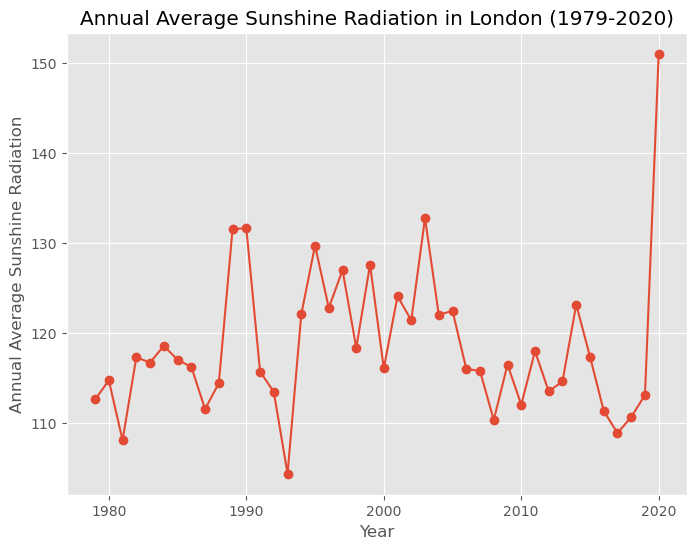

In [35]:
plt.plot(annual_radiation.index, annual_radiation, marker='o')
plt.xlabel("Year")
plt.ylabel("Annual Average Sunshine Radiation")
plt.title("Annual Average Sunshine Radiation in London (1979-2020)")
plt.grid(True)
plt.show()

In [38]:
tau, p_value = kendalltau(annual_radiation.index, annual_radiation.values)
print(p_value)
if p_value < 0.05:
    print("There is a significant trend.")
else:
    print("There is no significant trend.")

0.6725446687906484
There is no significant trend.
